# Spatial, temporal, and mechanical interrogation of Notch and E-cadherin signaling with mechanogenetic nanoprobes

### Movie Processing, Segmentation, and Area Analysis

This Jupyter notebook contains the python code used for movie processing and analysis of actin concentration. Much of the code is based off the following tutorial and is adapted to fit the specific application:
http://damcb.com/segmenting-nuclei.html
written by Guillaume Gay

Numpy, Scipy, Scikit-image, Pandas, and Matplatlib packages are used for this analysis

### 1. Python Setup: Import required functions

First import all required functions from skiamge, scipy, etc.

In [1]:
# use tifffile pluggin for imput/output
import skimage.io as io
io.use_plugin('tifffile')

#import thresholding methods to try
#import filters and shapes for image processing
from skimage.filters import threshold_otsu, threshold_li, median
from skimage.morphology import disk, square
from skimage.morphology import closing, dilation, opening

#functions for segmentation analysis
from skimage.measure import label
from skimage.measure import regionprops
from skimage.segmentation import clear_border

#analysis tools 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import distance as dist
import scipy.cluster.hierarchy as hier

%matplotlib inline

### 2. Load and Inspect the Movie

In [2]:
#import movie
movie = io.imread("file path here")

In [3]:
#set scaling values
time, x_size, y_size = movie.shape
t_scale = 1.0 #frame per second
xy_scale = 0.106 #µm per pixel
reduction_factor = 55 #divisor for ploting subset of 605 frame movie
sm_time = time//reduction_factor #reduced time series for ploting

Now inspect the movie

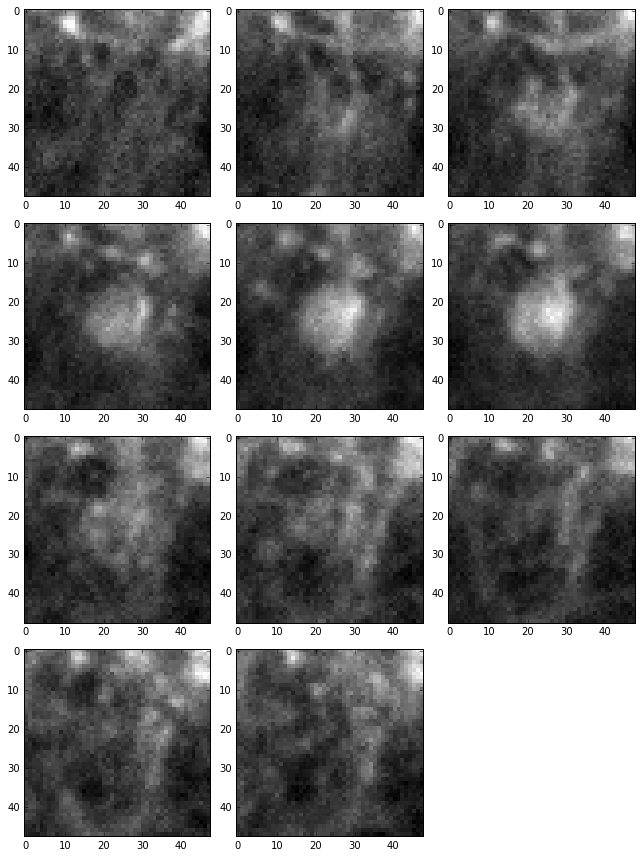

In [4]:
#plot movie snapshots
nrows = np.int(np.ceil(np.sqrt(sm_time)))
ncols = np.int(sm_time//nrows+1)

fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows)) 
count = 0
for n in range(0, time, reduction_factor):
    i = count // ncols
    j = count % ncols
    axes[i, j].imshow(movie[n, ...], 
                    interpolation='nearest', 
                    cmap='gray')
    count += 1

## Remove empty plots 
for ax in axes.ravel():
    if not(len(ax.images)):
        fig.delaxes(ax)
fig.tight_layout()

### 2. Set Threshold for Movie

The threshold is set by taking using the Otsu's thresholding method on the maximum intensity projection over the entire movie. The thresholding method can be adjusted to provide a more or less stringent segmentation

In [5]:
#produce maxium intensity projection
max_int_proj = movie.max(axis=0)

#set movie threshold
thresh_global = threshold_otsu(max_int_proj)

### 3. Perform Image Segmentation and Labeling

In [7]:
#set smooth size
smooth_size = 1 # pixels

#set image processing method used for segmentation
segmentation_meth = opening 
       
smoothed_stack = np.zeros_like(movie)
labeled_stack = smoothed_stack.copy()

## Labeling for each frame in time series:
for t, frame in enumerate(movie):
    smoothed = median(frame, disk(smooth_size))
    smoothed_stack[t] = smoothed
    im_max = smoothed.max()
    thresh = thresh_global
    if im_max < thresh_global:
        labeled_stack[t] = np.zeros(smoothed.shape, dtype=np.int32)
    else:
        bw = opening(smoothed > thresh, disk(1))
        cleared = bw.copy()
        clear_border(cleared)
        labeled_stack[t] = label(cleared)

Plot a summary figure of segmentation results. The above segementation parameters were used in analysis for publication. Adjust the parameters to tune the segmentation results.

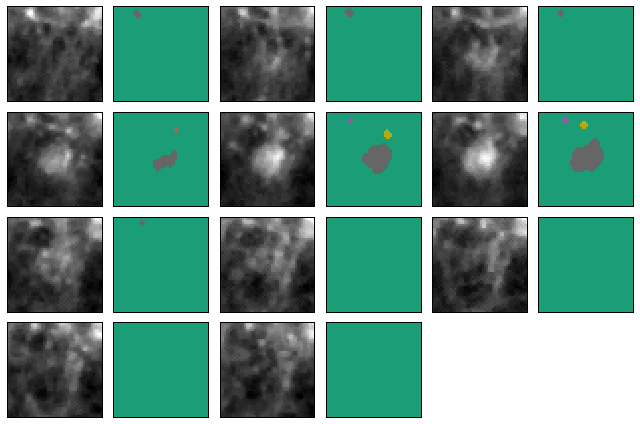

In [8]:
fig, axes = plt.subplots(nrows, ncols*2, figsize=(3*ncols, 1.5*nrows))

count = 0
for n in range(0, time, reduction_factor):
    i = count // ncols
    j = count % ncols * 2
    count += 1
    axes[i, j].imshow(smoothed_stack[n, ...], interpolation='nearest', cmap='gray')
    axes[i, j+1].imshow(labeled_stack[n, ...], interpolation='nearest', cmap='Dark2')
    
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
    axes[i, j+1].set_xticks([])
    axes[i, j+1].set_yticks([])

## Remove empty plots 
for ax in axes.ravel():
    if not(len(ax.images)):
        fig.delaxes(ax)

        
fig.tight_layout()

### 4.  Measure properties of the segmented shapes

save results to a pandas dataframe

In [9]:
#set up lists for dataFrame
properties = []
columns = ('x', 'y', 'time', 'I', 'A', 'I*A', 'radius')
indices = []

#add properties to lists
for t, frame in enumerate(labeled_stack):
    f_prop = regionprops(frame.astype(np.int), intensity_image = movie[t])
    for d in f_prop:
        radius = (d.area/np.pi)**0.5
        properties.append([d.weighted_centroid[0],
                        d.weighted_centroid[1],
                        t, d.mean_intensity, d.area,
                        d.mean_intensity * d.area,
                        radius])
        indices.append(d.label)
if not len(indices):
    all_props = pd.DataFrame([], index=[])
#create dataframe lists
indices = pd.Index(indices, name='label')
properties = pd.DataFrame(properties, index=indices, columns=columns)
#normalize intensity
properties['I'] /= properties['I'].max()

In [10]:
properties.head()

,x,y,time,I,A,I*A,radius
label,,,,,,,
1,3.968377,11.472533,0,0.941717,12,183221,1.954410
1,3.975907,11.821985,1,0.908802,16,235756,2.256758
1,3.510610,11.486326,2,0.914142,12,177856,1.954410
1,3.514651,11.489895,3,0.912498,12,177536,1.954410
1,3.508277,11.484464,4,0.933931,12,181706,1.954410


Plot summary of segmentation and labeling.

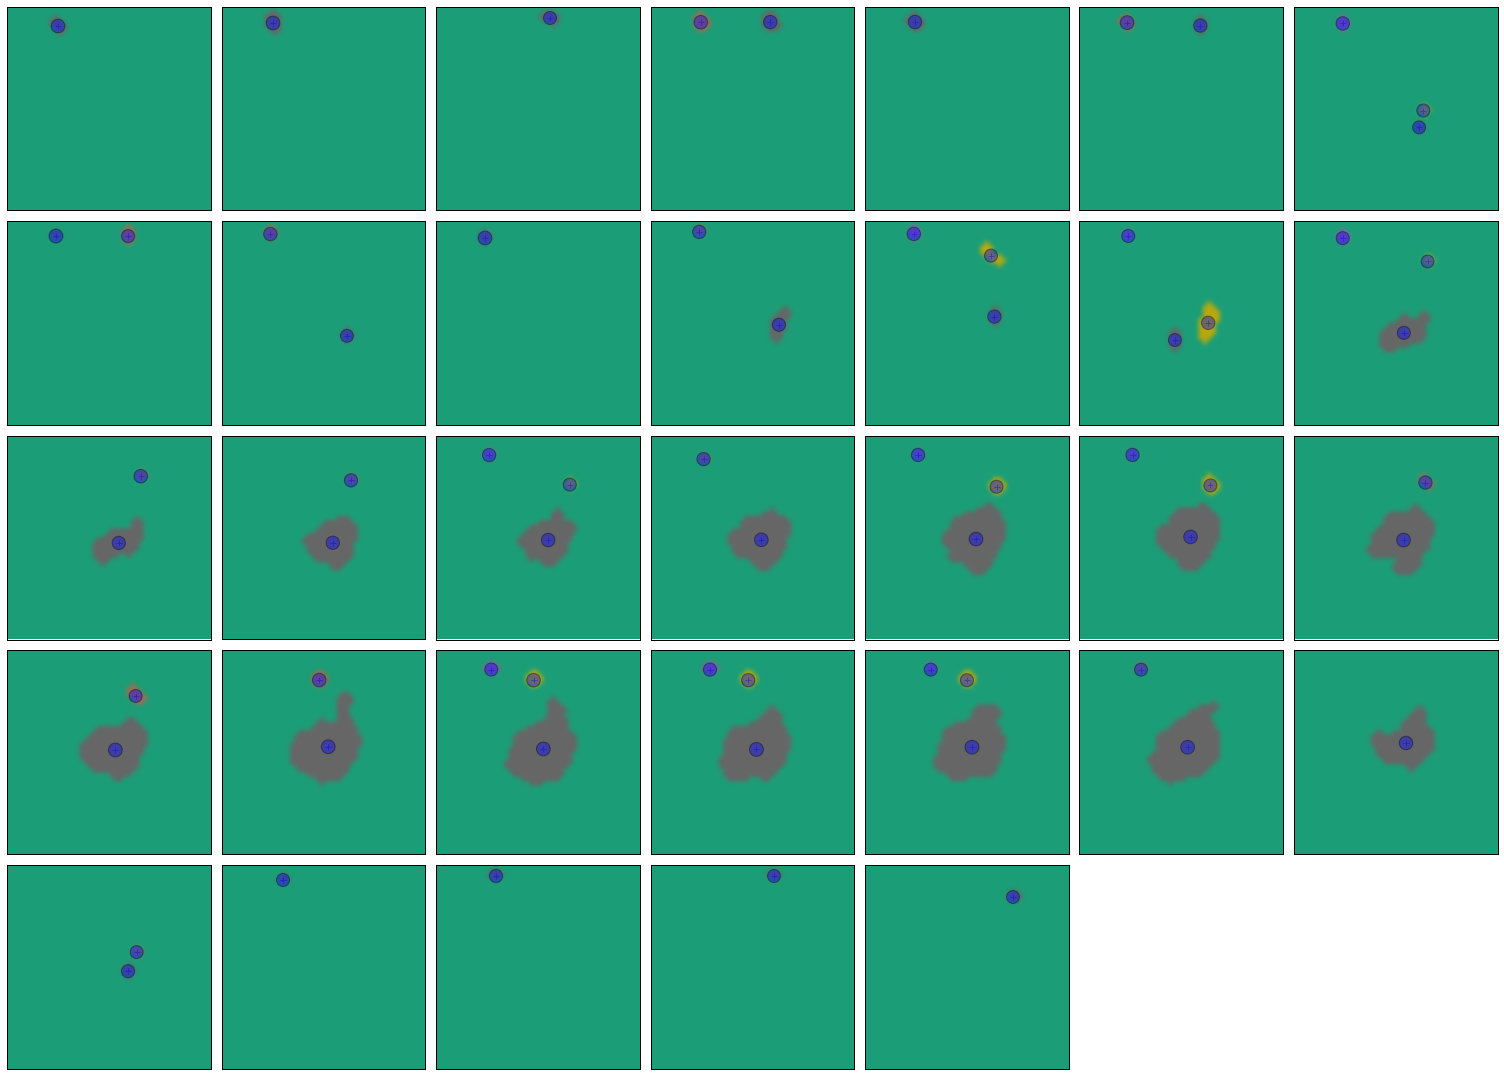

In [12]:
fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))

sm_time2 = time//11
    
nrows = np.int(np.ceil(np.sqrt(sm_time2)))
ncols = np.int(sm_time2//nrows+1)

    
count = 0
for n in range(0, time, 11):
    plane_props = properties[properties['time'] == n]
    if not(plane_props.shape[0]) :
        continue
    i = count // ncols
    j = count % ncols
    count += 1
    axes[i, j].imshow(labeled_stack[n, ...],
                    interpolation='bicubic', cmap='Dark2')
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
    x_lim = axes[i, j].get_xlim()
    y_lim = axes[i, j].get_ylim()    


    axes[i, j].scatter(plane_props['y'], plane_props['x'],  
                    s=plane_props['I']*200, alpha=0.4)
    axes[i, j].scatter(plane_props['y'], plane_props['x'],
                    s=40, marker='+', alpha=0.4)
    axes[i, j].set_xlim(x_lim)
    axes[i, j].set_ylim(y_lim)       

## Remove empty plots 
for ax in axes.ravel():
    if not(len(ax.images)):
            fig.delaxes(ax)  

fig.tight_layout()

### 5. Clustering to isolate region of interest from background actin filaments

In [21]:
#set maximum distance between 2 points in a cluster
max_dist = 30 #pixels

positions = properties[['x', 'y']].copy()

dist_mat = dist.squareform(dist.pdist(positions.values))
link_mat = hier.linkage(dist_mat)
cluster_idx = hier.fcluster(link_mat, max_dist,
                            criterion='distance')
properties['new_label'] = cluster_idx
properties.set_index('new_label', drop=True, append=False, inplace=True)
properties.index.name = 'label'
properties = properties.sort_index()

In [14]:
def df_average(df, weights_column):
    '''Computes the average on each columns of a dataframe, weighted
    by the values of the column `weight_columns`.
    
    Parameters:
    -----------
    df: a pandas DataFrame instance
    weights_column: a string, the column name of the weights column 
    
    Returns:
    --------
    
    values: pandas DataFrame instance with the same column names as `df`
        with the weighted average value of the column
    '''
    
    values = df.copy().iloc[0]
    norm = df[weights_column].sum()
    for col in df.columns:
        try:
            v = (df[col] * df[weights_column]).sum() / norm
        except TypeError:
            v = df[col].iloc[0]
        values[col] = v
    return values

cluster_positions = properties.groupby(level='label').apply(df_average, 'I*A')

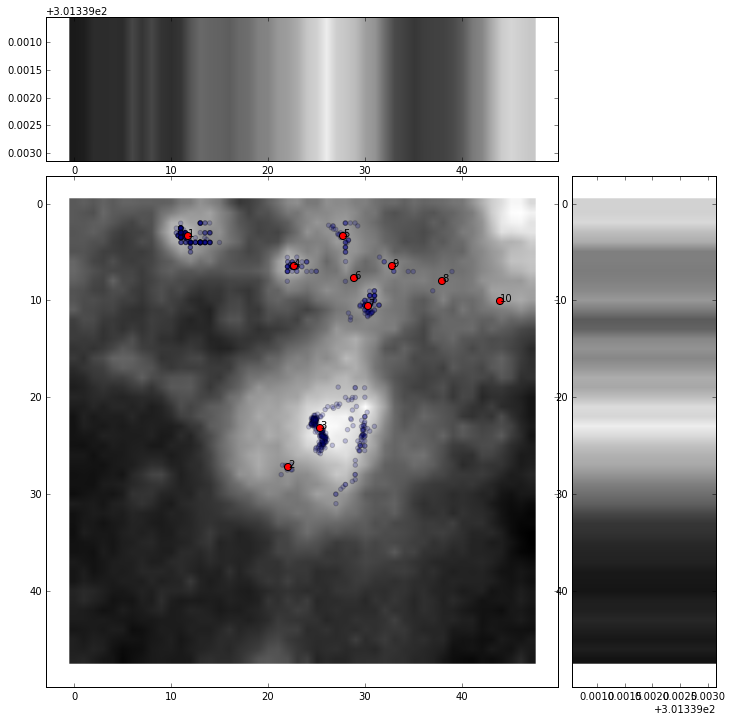

In [15]:
#plot summary of clustering results

labels = cluster_positions.index.tolist()

fig = plt.figure(figsize=(12, 12))
colors = plt.cm.jet(properties.index.astype(np.int32))

# xy projection:
ax_xy = fig.add_subplot(111)
ax_xy.imshow(movie.max(axis=0), cmap='gray')
ax_xy.scatter(properties['y'],
            properties['x'],
            c=colors, alpha=0.2)


ax_xy.scatter(cluster_positions['y'],
            cluster_positions['x'],
            c='r', s=50, alpha=1.)


for i, txt in enumerate(labels):
    ax_xy.annotate(txt, (cluster_positions.iloc[i]['y'], cluster_positions.iloc[i]['x']))

divider = make_axes_locatable(ax_xy)
ax_yz = divider.append_axes("top", 2, pad=0.2, sharex=ax_xy)
ax_yz.imshow(movie.max(axis=1), aspect=time/xy_scale, cmap='gray')
ax_yz.scatter(properties['y'],
            properties['time'],
            c=colors, alpha=0.2)

ax_yz.scatter(cluster_positions['y'],
            cluster_positions['time'],
            c='r', s=50, alpha=1.)


ax_zx = divider.append_axes("right", 2, pad=0.2, sharey=ax_xy)
ax_zx.imshow(movie.max(axis=2).T, aspect=xy_scale/time, cmap='gray')
ax_zx.scatter(properties['time'],
            properties['x'],
            c=colors, alpha=0.2)

ax_zx.scatter(cluster_positions['time'],
            cluster_positions['x'],
            c='r', s=50, alpha=1.)

plt.draw()

### 6. Clean data by selecting clusters of interest

In [16]:
#select clusters of interest
properties_clean = properties[(properties.index == 2) | 
                              (properties.index == 3)]

#add together segments that occur at the same time
properties_clean.groupby(properties_clean['time']).sum()

properties_clean.head()

,x,y,time,I,A,I*A,radius
label,,,,,,,
2,27.491112,22.490316,144,0.846323,12,164661,1.954410
2,27.984427,21.359051,142,0.834597,11,148848,1.871205
2,27.001936,21.493478,145,0.841651,12,163752,1.954410
2,27.506485,21.991620,143,0.836928,14,189972,2.111004
2,27.494865,22.388482,148,0.857991,27,375595,2.931615


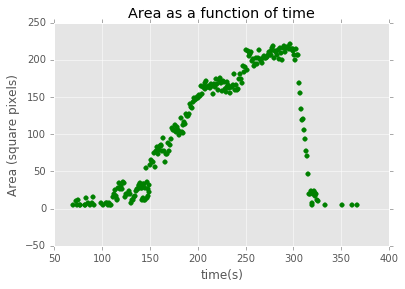

In [20]:
#plot the cleaned data
plt.style.use('ggplot')

plt.scatter(properties_clean['time'], properties_clean['A'], color = 'Green')
plt.xlabel('time(s)')
plt.ylabel('Area (square pixels)')
plt.title('Area as a function of Time')